# EDA

- RMSE : 23724.4207

In [1]:
!pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [2]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

In [3]:
# 열 다 보이게 설정
pd.set_option('display.max_columns', None)
# 행 다 보이게 설정
pd.set_option('display.max_rows', None)

In [4]:
# 데이터 로드
train_path = '/root/AI_STAGE/upstageailab-ml-competition-ml-2/1.Data/train.csv'
test_path  = '/root/AI_STAGE/upstageailab-ml-competition-ml-2/1.Data/test.csv'
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# 전처리 위해 데이터 합치고 확인
train['data'] = 0
test['data'] = 1
concat = pd.concat([train, test])

print(concat.shape)
print(concat['data'].value_counts())

(1128094, 53)
0    1118822
1       9272
Name: data, dtype: int64


In [5]:
concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 53 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1128094 non-null  object 
 1   번지                      1127867 non-null  object 
 2   본번                      1128019 non-null  float64
 3   부번                      1128019 non-null  float64
 4   아파트명                    1125958 non-null  object 
 5   전용면적(㎡)                 1128094 non-null  float64
 6   계약년월                    1128094 non-null  int64  
 7   계약일                     1128094 non-null  int64  
 8   층                       1128094 non-null  int64  
 9   건축년도                    1128094 non-null  int64  
 10  도로명                     1128094 non-null  object 
 11  해제사유발생일                 6195 non-null     float64
 12  등기신청일자                  1128094 non-null  object 
 13  거래유형                    1128094 non-null  object 
 14  중개사소재

In [6]:
# 보기 편하게 바꾸기

concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

In [7]:
# 결측치는 아닌데 의미 없는 형식적 값 찾기

def detect_fake_nulls(df, suspect_values=['-', ' ', '', '.', '없음', 'nan']):
    result = {}
    for col in df.columns:
        if concat[col].dtype == 'object':
            val_counts = concat[col].value_counts(dropna=False)
            found = val_counts[val_counts.index.isin(suspect_values)]
            if not found.empty:
                result[col] = found
    return result

fake_nulls = detect_fake_nulls(concat)
for col, vals in fake_nulls.items():
    print(f"🔎 {col} 컬럼에서 의미 없는 값 발견:")
    print(vals)
    print()

# 결측치로 인식하도록 채우기
concat['도로명'] = concat['도로명'].replace(' ', np.nan)
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)
concat['k-시행사'] = concat['k-시행사'].replace('.', np.nan)
concat['k-시행사'] = concat['k-시행사'].replace('-', np.nan)
concat['k-홈페이지'] = concat['k-홈페이지'].replace('없음', np.nan)
concat['k-홈페이지'] = concat['k-홈페이지'].replace('.', np.nan)

🔎 도로명 컬럼에서 의미 없는 값 발견:
     1211
Name: 도로명, dtype: int64

🔎 등기신청일자 컬럼에서 의미 없는 값 발견:
     1111271
Name: 등기신청일자, dtype: int64

🔎 거래유형 컬럼에서 의미 없는 값 발견:
-    1086451
Name: 거래유형, dtype: int64

🔎 중개사소재지 컬럼에서 의미 없는 값 발견:
-    1090013
Name: 중개사소재지, dtype: int64

🔎 k-시행사 컬럼에서 의미 없는 값 발견:
.    868
-    152
Name: k-시행사, dtype: int64

🔎 k-홈페이지 컬럼에서 의미 없는 값 발견:
없음    3628
.       72
Name: k-홈페이지, dtype: int64



In [8]:
# 의미없는 값 결측치로 인식시키고 결측률 보기
# 열 전체를 넣고 스캔하기

for col in concat.columns:
    nunique = concat[col].nunique(dropna=False)
    missing_ratio = concat[col].isna().mean()
    missing_count = concat[col].isnull().sum()
    col_type = concat.dtypes[col]
    print(f"📌 {col:30} | 데이터타입: {col_type} | 고유값: {nunique:6} | 결측개수: {missing_count} | 결측률: {missing_ratio:.2%}")

📌 시군구                            | 데이터타입: object | 고유값:    339 | 결측개수: 0 | 결측률: 0.00%
📌 번지                             | 데이터타입: object | 고유값:   6579 | 결측개수: 227 | 결측률: 0.02%
📌 본번                             | 데이터타입: float64 | 고유값:   1524 | 결측개수: 75 | 결측률: 0.01%
📌 부번                             | 데이터타입: float64 | 고유값:    330 | 결측개수: 75 | 결측률: 0.01%
📌 아파트명                           | 데이터타입: object | 고유값:   6550 | 결측개수: 2136 | 결측률: 0.19%
📌 전용면적                           | 데이터타입: float64 | 고유값:  14670 | 결측개수: 0 | 결측률: 0.00%
📌 계약년월                           | 데이터타입: int64 | 고유값:    201 | 결측개수: 0 | 결측률: 0.00%
📌 계약일                            | 데이터타입: int64 | 고유값:     31 | 결측개수: 0 | 결측률: 0.00%
📌 층                              | 데이터타입: int64 | 고유값:     73 | 결측개수: 0 | 결측률: 0.00%
📌 건축년도                           | 데이터타입: int64 | 고유값:     60 | 결측개수: 0 | 결측률: 0.00%
📌 도로명                            | 데이터타입: object | 고유값:   9245 | 결측개수: 1211 | 결측률: 0.11%
📌 해제사유발생일                        | 데이터타입: flo

In [9]:
# print(concat.shape[0] * 0.8) = 902475.2000000001
# Null값이 90만개 이상인 칼럼은 삭제
# print('* 결측치가 90만개 이하인 변수들 :', list(concat.columns[concat.isnull().sum() <= 900000]))     # 남겨질 변수들은 아래와 같습니다.
# print('* 결측치가 90만개 이상인 변수들 :', list(concat.columns[concat.isnull().sum() >= 900000]))

# * 결측치가 90만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'data']
# * 결측치가 90만개 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', '고용보험관리번호']

# 결측치 90만개 이상인 값과 이하지만 필요없는 것 제외
# 필요없어 보이는 것 : k-전화번호, k-팩스번호, 사용허가여부, 관리비 업로드, k-수정일자

valid_cols = concat.columns[concat.isnull().sum() <= 900000]
exclude_cols = ['k-전화번호', 'k-팩스번호', '사용허가여부', '관리비 업로드', 'k-수정일자']

select = [col for col in valid_cols if col not in exclude_cols]
concat_select = concat[select]

concat.shape, concat_select.shape

((1128094, 53), (1128094, 39))

In [10]:
# 결측 채우고 info 본 후에 데이터 타입 변환
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')

In [11]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리
# 숫자형 분리 pd.api.types.is_numeric_dtype
con_columns = []
cat_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        con_columns.append(column)
    else:
        cat_columns.append(column)

def null_summary(df, columns):
    result = pd.DataFrame({
        '결측 개수': df[columns].isnull().sum(),
        '결측 비율(%)': df[columns].isnull().mean() * 100
    })
    return result[result['결측 개수'] > 0].sort_values('결측 비율(%)', ascending=False)

print("📊 연속형 변수 결측치 요약")
display(null_summary(concat_select, con_columns))

print("📊 범주형 변수 결측치 요약")
display(null_summary(concat_select, cat_columns))


📊 연속형 변수 결측치 요약


,결측 개수,결측 비율(%)
k-전체동수,877207,77.760098
건축면적,876279,77.677835
주차대수,876277,77.677658
좌표X,876232,77.673669
좌표Y,876232,77.673669
k-주거전용면적,876170,77.668173
k-전용면적별세대현황(60㎡이하),876170,77.668173
k-전용면적별세대현황(60㎡~85㎡이하),876170,77.668173
k-85㎡~135㎡이하,876170,77.668173
k-전체세대수,876125,77.664184


📊 범주형 변수 결측치 요약


,결측 개수,결측 비율(%)
세대전기계약방법,885389,78.485392
k-시행사,878854,77.906096
청소비관리형태,877751,77.808321
k-건설사(시공사),877637,77.798215
경비비관리형태,877561,77.791478
"k-단지분류(아파트,주상복합등등)",877273,77.765949
단지승인일,876854,77.728806
k-복도유형,876454,77.693348
k-사용검사일-사용승인일,876259,77.676062
단지신청일,876187,77.669680


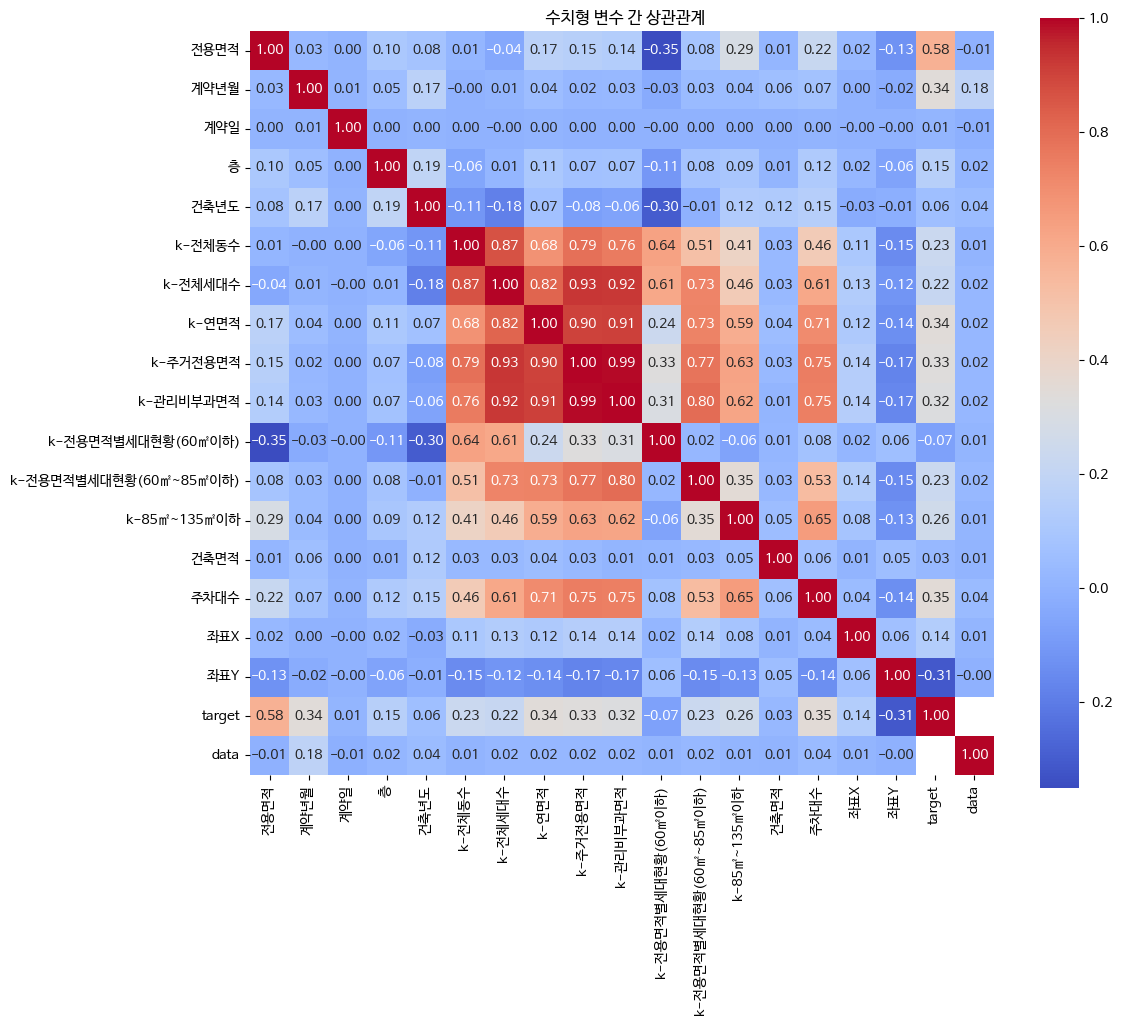

In [12]:
# 위의 그래프로 수치형 feature의 결측값이 20% 이상임을 확인
# feature를 지우거나 임의의 값을 넣기는 어렵다고 판단하여
# 결측치 탐지 및 처리 전 연속형 변수 상관관계 보기

# 1. 수치형 변수만 선택
numeric_cols = concat_select.select_dtypes(include=['float64', 'int64']).columns

# 2. 상관관계 계산
corr = concat_select[numeric_cols].corr()

# 3. 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("📊 수치형 변수 간 상관관계")
plt.show()

In [13]:
# 시각화 했을 때 feature가 많아서 한눈에 안 들어오는 상황 발생
# 상관계수가 0.7 이상이면 강한 상관관계가 있다고 판단하여
# 0.7이상인 쌍을 찾아냄

# 상관관계 기반으로 중복 feature 쌍 탐지 및 삭제 후보 추천

# 연속형 변수만 추출
numeric_cols = con_columns  # ← 너가 나눠둔 연속형 변수 리스트

# 상관관계 행렬 (절댓값 기준)
corr_matrix = concat_select[numeric_cols].corr().abs()

# 상삼각 행렬로 중복 제거
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 상관계수 0.7 초과인 변수쌍 추출
high_corr_pairs = [(col, row, upper.loc[row, col])
                   for col in upper.columns
                   for row in upper.index
                   if pd.notnull(upper.loc[row, col]) and upper.loc[row, col] > 0.7]

# 출력
for col1, col2, score in sorted(high_corr_pairs, key=lambda x: -x[2]):
    print(f"🔁 {col1} ↔ {col2} : 상관계수 = {score:.2f}")


🔁 k-관리비부과면적 ↔ k-주거전용면적 : 상관계수 = 0.99
🔁 k-주거전용면적 ↔ k-전체세대수 : 상관계수 = 0.93
🔁 k-관리비부과면적 ↔ k-전체세대수 : 상관계수 = 0.92
🔁 k-관리비부과면적 ↔ k-연면적 : 상관계수 = 0.91
🔁 k-주거전용면적 ↔ k-연면적 : 상관계수 = 0.90
🔁 k-전체세대수 ↔ k-전체동수 : 상관계수 = 0.87
🔁 k-연면적 ↔ k-전체세대수 : 상관계수 = 0.82
🔁 k-전용면적별세대현황(60㎡~85㎡이하) ↔ k-관리비부과면적 : 상관계수 = 0.80
🔁 k-주거전용면적 ↔ k-전체동수 : 상관계수 = 0.79
🔁 k-전용면적별세대현황(60㎡~85㎡이하) ↔ k-주거전용면적 : 상관계수 = 0.77
🔁 k-관리비부과면적 ↔ k-전체동수 : 상관계수 = 0.76
🔁 주차대수 ↔ k-주거전용면적 : 상관계수 = 0.75
🔁 주차대수 ↔ k-관리비부과면적 : 상관계수 = 0.75
🔁 k-전용면적별세대현황(60㎡~85㎡이하) ↔ k-연면적 : 상관계수 = 0.73
🔁 k-전용면적별세대현황(60㎡~85㎡이하) ↔ k-전체세대수 : 상관계수 = 0.73
🔁 주차대수 ↔ k-연면적 : 상관계수 = 0.71


### 수치형 feature eda

- 결측비율이 20% 넘어가서 임의로 채우기 전 상관관계 봄
- 상관계수가 0.7이상인 쌍들을 찾아냄

- ['k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하']가 이름도 비슷하고 feature끼리 상관관계가 있어서 PCA 진행해보기로 함
- 다른 feature(전용면적, 주차대수 등)와 상관관계가 있는 ['k-관리비부과면적','k-연면적','k-전체동수'] feature 삭제 예정

- 남은 결측치들은 값을 채워야겠다고 생각
- 부동산 가격 예측이니 지역별로 다르게 채워야 한다고 생각함
- 같은 구 내에서도 동에 따라 가격이 다를 수 있기 때문
- ['건축면적', '주차대수', '좌표X', '좌표Y', 'k-주거전용면적', 'k-전체세대수'] 는 ['시군구'] feature를 ['구']와 ['동']으로 구분해주고, 동 - 구 - 전체 평균으로 채워줄 생각

In [14]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
# 숫자형 분리 pd.api.types.is_numeric_dtype

cat_columns2 = []
con_columns2 = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        con_columns2.append(column)
    else:
        cat_columns2.append(column)

print("연속형 변수:", con_columns2)
print("범주형 변수:", cat_columns2)

def null_summary(df, columns):
    result = pd.DataFrame({
        '결측 개수': df[columns].isnull().sum(),
        '결측 비율(%)': df[columns].isnull().mean() * 100
    })
    return result[result['결측 개수'] > 0].sort_values('결측 비율(%)', ascending=False)

print("📊 연속형 변수 결측치 요약")
display(null_summary(concat_select, con_columns2))

print("📊 범주형 변수 결측치 요약")
display(null_summary(concat_select, cat_columns2))


연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'data']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '단지신청일']
📊 연속형 변수 결측치 요약


,결측 개수,결측 비율(%)
k-전체동수,877207,77.760098
건축면적,876279,77.677835
주차대수,876277,77.677658
좌표X,876232,77.673669
좌표Y,876232,77.673669
k-주거전용면적,876170,77.668173
k-전용면적별세대현황(60㎡이하),876170,77.668173
k-전용면적별세대현황(60㎡~85㎡이하),876170,77.668173
k-85㎡~135㎡이하,876170,77.668173
k-전체세대수,876125,77.664184


📊 범주형 변수 결측치 요약


,결측 개수,결측 비율(%)
세대전기계약방법,885389,78.485392
k-시행사,878854,77.906096
청소비관리형태,877751,77.808321
k-건설사(시공사),877637,77.798215
경비비관리형태,877561,77.791478
"k-단지분류(아파트,주상복합등등)",877273,77.765949
단지승인일,876854,77.728806
k-복도유형,876454,77.693348
k-사용검사일-사용승인일,876259,77.676062
단지신청일,876187,77.669680


In [15]:
# 크래머스 브이는 NaN값 반영 못함
# 범주형 변수 결측치 채우기

cat_with_na = [
    '세대전기계약방법', 'k-시행사', '청소비관리형태', 'k-건설사(시공사)',
    '경비비관리형태', 'k-단지분류(아파트,주상복합등등)', '단지승인일',
    'k-복도유형', 'k-사용검사일-사용승인일', '단지신청일',
    'k-난방방식', 'k-관리방식', 'k-세대타입(분양형태)',
    '기타/의무/임대/임의=1/2/3/4', '아파트명', '도로명', '번지'
]

for col in cat_with_na:
   
    concat_select[col] = concat_select[col].fillna("Unknown")


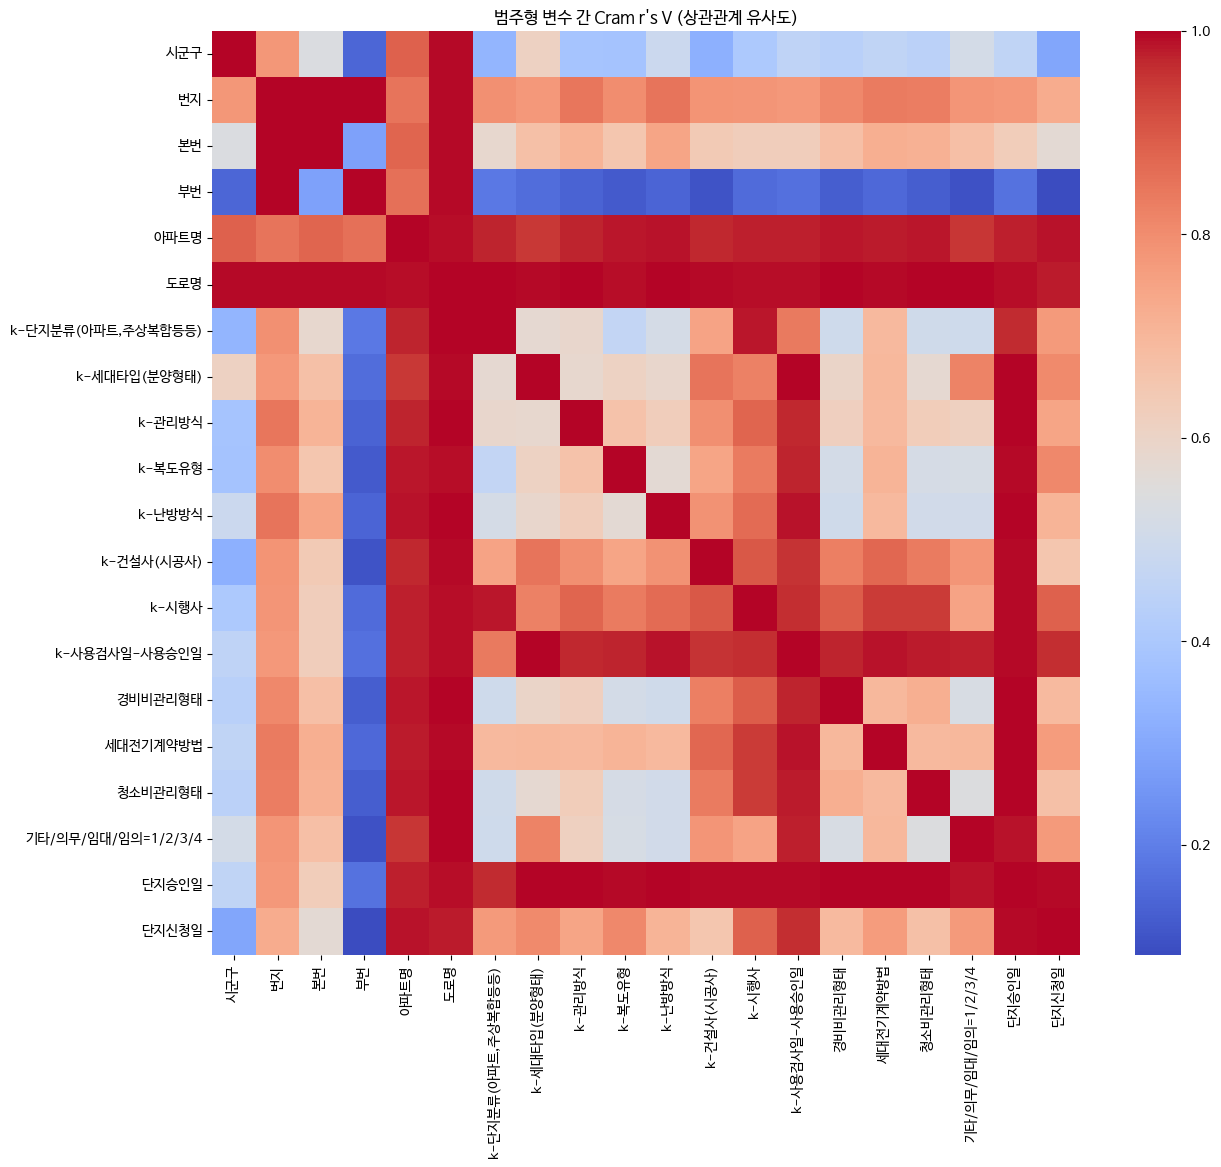

In [16]:
# 범주형 feature들 관계 보기

from scipy.stats import chi2_contingency

# Cramér's V 계산 함수
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# 범주형 변수 리스트

cat_cols = cat_columns2  # 이미 나눈 리스트

# 결과 저장용 매트릭스
cramer_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols)

for col1 in cat_cols:
    for col2 in cat_cols:
        if col1 == col2:
            cramer_matrix.loc[col1, col2] = 1.0
        else:
            try:
                cramer_matrix.loc[col1, col2] = cramers_v(concat_select[col1], concat_select[col2])
            except:
                cramer_matrix.loc[col1, col2] = np.nan

plt.figure(figsize=(14, 12))
sns.heatmap(cramer_matrix.astype(float), cmap='coolwarm', annot=False)
plt.title("범주형 변수 간 Cramér's V (상관관계 유사도)")
plt.show()


In [17]:
# 유니크 값이 낮으면 값이 다양하지 않아 유사성이 높을 수 있다고 함
# 변주형 중 unique값이 낮은 것 보기

for col in cat_columns2:
    print(f"{col}: {concat_select[col].nunique()}")


시군구: 339
번지: 6579
본번: 1524
부번: 330
아파트명: 6550
도로명: 9245
k-단지분류(아파트,주상복합등등): 6
k-세대타입(분양형태): 4
k-관리방식: 4
k-복도유형: 6
k-난방방식: 5
k-건설사(시공사): 345
k-시행사: 555
k-사용검사일-사용승인일: 675
경비비관리형태: 5
세대전기계약방법: 3
청소비관리형태: 5
기타/의무/임대/임의=1/2/3/4: 5
단지승인일: 737
단지신청일: 261


In [18]:
# 크래머스 브이 수치로 보기
# unique 값이 낮은 것과 비슷한지 주의해서 봄

threshold = 0.8
high_corr_pairs = []

for i in range(len(cat_cols)):
    for j in range(i + 1, len(cat_cols)):
        col1, col2 = cat_cols[i], cat_cols[j]
        val = cramer_matrix.loc[col1, col2]
        if pd.notnull(val) and float(val) >= threshold:
            high_corr_pairs.append((col1, col2, float(val)))

for col1, col2, score in sorted(high_corr_pairs, key=lambda x: -x[2]):
    print(f"🔁 {col1} ↔ {col2} : Cramér's V = {score:.2f}")


🔁 경비비관리형태 ↔ 단지승인일 : Cramér's V = 1.00
🔁 세대전기계약방법 ↔ 단지승인일 : Cramér's V = 1.00
🔁 청소비관리형태 ↔ 단지승인일 : Cramér's V = 1.00
🔁 번지 ↔ 본번 : Cramér's V = 1.00
🔁 k-난방방식 ↔ 단지승인일 : Cramér's V = 1.00
🔁 번지 ↔ 부번 : Cramér's V = 1.00
🔁 도로명 ↔ k-단지분류(아파트,주상복합등등) : Cramér's V = 1.00
🔁 도로명 ↔ 경비비관리형태 : Cramér's V = 1.00
🔁 도로명 ↔ 기타/의무/임대/임의=1/2/3/4 : Cramér's V = 1.00
🔁 k-세대타입(분양형태) ↔ 단지승인일 : Cramér's V = 1.00
🔁 도로명 ↔ 청소비관리형태 : Cramér's V = 1.00
🔁 도로명 ↔ k-관리방식 : Cramér's V = 1.00
🔁 도로명 ↔ k-난방방식 : Cramér's V = 1.00
🔁 k-세대타입(분양형태) ↔ k-사용검사일-사용승인일 : Cramér's V = 1.00
🔁 k-관리방식 ↔ 단지승인일 : Cramér's V = 1.00
🔁 시군구 ↔ 도로명 : Cramér's V = 1.00
🔁 k-시행사 ↔ 단지승인일 : Cramér's V = 1.00
🔁 도로명 ↔ 세대전기계약방법 : Cramér's V = 1.00
🔁 단지승인일 ↔ 단지신청일 : Cramér's V = 1.00
🔁 본번 ↔ 도로명 : Cramér's V = 0.99
🔁 부번 ↔ 도로명 : Cramér's V = 0.99
🔁 k-건설사(시공사) ↔ 단지승인일 : Cramér's V = 0.99
🔁 k-복도유형 ↔ 단지승인일 : Cramér's V = 0.99
🔁 도로명 ↔ k-세대타입(분양형태) : Cramér's V = 0.99
🔁 k-사용검사일-사용승인일 ↔ 단지승인일 : Cramér's V = 0.99
🔁 도로명 ↔ k-건설사(시공사) : Cramér's V = 0.99
🔁 번지 ↔ 도로명 : Cr

In [19]:
# 크래머스 브이 해석 : 값의 범위 0~1 -> 1에 가까울수록 연관성 높음을 의미
# threshold 0.8을 기준으로 엄청 강한 연관성을 가진 feature 삭제

drop_cat_cols = [
    '본번',
    '부번',
    '도로명',
    '단지승인일',
    '단지신청일',
    'k-세대타입(분양형태)',
    'k-관리방식',
    'k-난방방식',
    'k-복도유형',
    '세대전기계약방법',
    '경비비관리형태',
    '청소비관리형태',
    '기타/의무/임대/임의=1/2/3/4',]

# 제거 적용
concat_select.drop(columns=drop_cat_cols, inplace=True)

# 제거 후 결과 확인
print(f"✅ 제거 완료! 현재 변수 수: {concat_select.shape[1]}")

✅ 제거 완료! 현재 변수 수: 26


In [22]:
# 이상치 탐지 및 처리

def detect_outliers_iqr(df, columns, iqr_scale=1.5):
    outlier_summary = []

    for col in columns:
        if df[col].isnull().all():
            continue

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_scale * IQR
        upper_bound = Q3 + iqr_scale * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = outliers.shape[0]
        outlier_ratio = outlier_count / df.shape[0] * 100

        outlier_summary.append({
            '변수': col,
            '이상치 개수': outlier_count,
            '이상치 비율(%)': round(outlier_ratio, 2)
        })

    return pd.DataFrame(outlier_summary).sort_values('이상치 비율(%)', ascending=False)


In [23]:
# 학습용 데이터만 추출
train_data = concat_select[concat_select['data'] == 0]

# 이상치 탐지 요약표 생성
outlier_df = detect_outliers_iqr(train_data, con_columns_final)

# 출력
import pandas as pd
pd.set_option('display.max_rows', 100)  # 길어도 잘림 방지
display(outlier_df)


,변수,이상치 개수,이상치 비율(%)
0,전용면적,89248,7.98
17,target,75622,6.76
13,건축면적,22653,2.02
14,주차대수,21045,1.88
10,k-전용면적별세대현황(60㎡이하),19470,1.74
7,k-연면적,19499,1.74
8,k-주거전용면적,18498,1.65
11,k-전용면적별세대현황(60㎡~85㎡이하),17363,1.55
5,k-전체동수,17129,1.53
3,층,17009,1.52


### 범주형 feature eda

- 범주형 feature의 결측치를 채우는 게 어려움
- 전처리를 위해 임의로 'Unknown'으로 채웠으나, 정확한 값을 반영하지 않아 전처리의 어려움이 있을 것으로 예상

- 범주형 feature의 관계를 보고 관계가 있는 변수를 삭제해주었음

- 이후에 이상치 처리를 진행하면 될 것 같음
- 이상치는 자주 사용되는 IQR 방식을 사용할 것이며, 수치형 변수와 범주형 변수를 합쳐 이상치가 많은 상위의 몇 개를 가져다 쓸 것임

**주의! 어떻게 처리할 건지 파악하는 것으로, 노트북 내 결측치나 이상치 처리가 되지 않았음**